<a href="https://colab.research.google.com/github/evndttr/workshop_notebooks/blob/main/Reading_like_a_machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Using This Notebook

This notebook is an interactive Python document. It mixes text explanations with code cells that you can run.

Each gray box below is a code cell. To run it:

Click the play button on the left side of the cell, or
Press Shift + Enter on your keyboard.
When you run a cell, the code inside is executed, and the output (like a chart or number) will appear right below it.

#Introduction
In this notebook, we’ll explore how computers can learn to recognize handwritten digits — a classic problem in machine learning and one of the earliest examples of image classification. Using the built-in Digits dataset from Scikit-learn, we’ll walk through each step of the process: from understanding raw pixel data to training a simple model and interpreting its predictions.

Learning Objectives

* Understand what features, weights, and biases mean in a machine learning model.
* Visualize how numerical data (pixels) can represent images.
* Learn how models train by identifying statistical patterns in data.
* See how models make predictions (inference) after training.
* Experiment interactively by selecting features and evaluating model performance.
* Create a simple rule-based classifier to test your intuition about which features matter most.



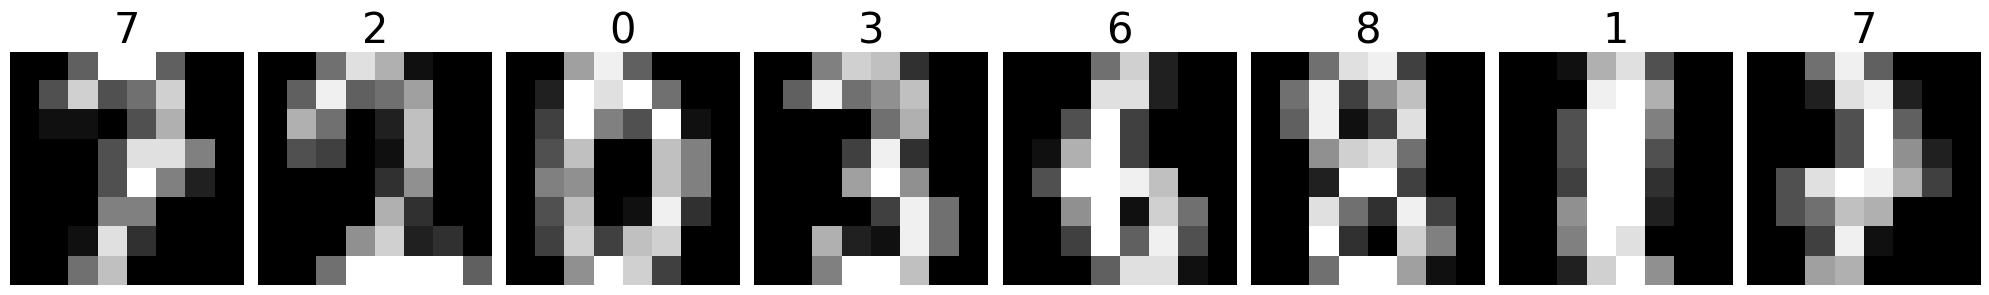

In [ ]:
#@title Loading and Examining the Data

#@markdown For this workshop, we will use the Digits dataset in the Scikit-learn Python library.
#@markdown This dataset contains 1,797 small grayscale images of handwritten digits (0–9).

#@markdown The data is derived from the MNIST dataset, originally collected between 1988–1994 from handwritten ZIP codes on envelopes processed in Buffalo, NY, and by U.S. Census Bureau employees and American high school students.
#@markdown It was used to develop some of the first Optical Character Recognition (OCR) systems.

#@markdown Each image is only 8×8 pixels (64 pixels total), making this a lightweight and accessible dataset to experiment with.

#@markdown We'll begin by visualizing a random selection of 8 images along with their corresponding labels.

#@markdown Each time you press play to run the code, a new set of random examples are drawn.


import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

# Load dataset
digits = load_digits()

# Pick 8 random indices (no repeats)
indices = np.random.choice(len(digits.images), 8, replace=False)

# Create 1×8 grid
fig, axes = plt.subplots(1, 8, figsize=(20, 160))

for ax, idx in zip(axes.ravel(), indices):
    image = digits.images[idx]
    label = digits.target[idx]
    ax.imshow(image, cmap='gray', vmin=0, vmax=16)
    ax.set_title(f"{label}", fontsize=30)
    ax.axis('off')

plt.tight_layout()
plt.show()




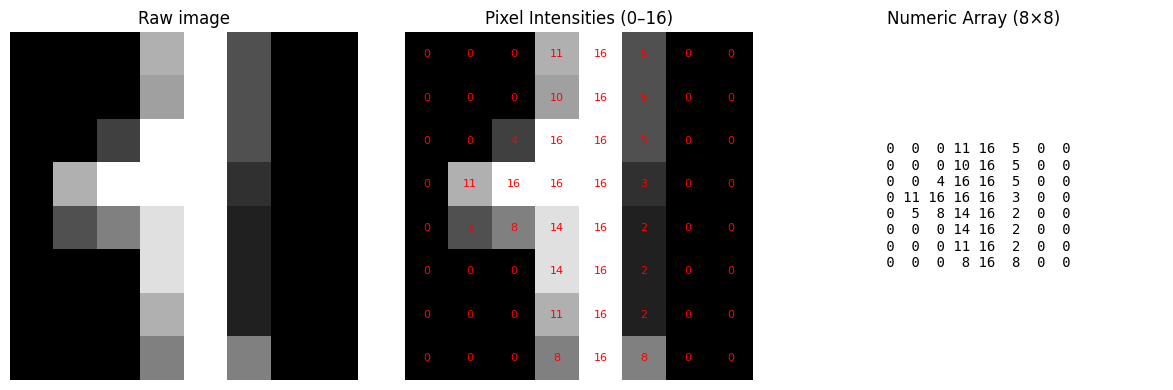

In [ ]:
#@title How does the computer "read" the images?
#@markdown When we load the images, the computer interprets each one as a grid of numerical intensity values, where each pixel is assigned a number between 0 and 16.
#@markdown These values describe how dark or light each pixel is.
#@markdown
#@markdown The model doesn’t see a “picture” of a digit — it sees an array of numbers that encode brightness.
#@markdown By processing these arrays, machine-learning models can learn to distinguish patterns between digits.

# Choose which sample to visualize
i = np.random.choice(len(digits.images))
image = digits.images[i]
features = digits.data[i]
label = digits.target[i]

# Create figure with 3 columns (array + 2 plots)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Right: Raw image
axes[0].imshow(features.reshape(8, 8), cmap='gray')
axes[0].set_title("Raw image")
axes[0].axis('off')

# Middle: Image with pixel intensities
axes[1].imshow(image, cmap='gray', vmin=0, vmax=16)
for (x, y), val in np.ndenumerate(image):
    axes[1].text(y, x, int(val), ha='center', va='center',
                 color='red', fontsize=8)
axes[1].set_title("Pixel Intensities (0–16)")
axes[1].axis('off')

# Left: Numerical Array
axes[2].axis('off')
text = "\n".join(" ".join(f"{int(v):2d}" for v in row) for row in image)
axes[2].text(0.5, 0.5, text, family="monospace", fontsize=10,
             ha='center', va='center')
axes[2].set_title("Numeric Array (8×8)")

plt.tight_layout()
plt.show()


In [ ]:
#@title This is what each array of numbers looks like that is fed into the model

print(image)

[[ 0.  0.  0. 11. 16.  5.  0.  0.]
 [ 0.  0.  0. 10. 16.  5.  0.  0.]
 [ 0.  0.  4. 16. 16.  5.  0.  0.]
 [ 0. 11. 16. 16. 16.  3.  0.  0.]
 [ 0.  5.  8. 14. 16.  2.  0.  0.]
 [ 0.  0.  0. 14. 16.  2.  0.  0.]
 [ 0.  0.  0. 11. 16.  2.  0.  0.]
 [ 0.  0.  0.  8. 16.  8.  0.  0.]]


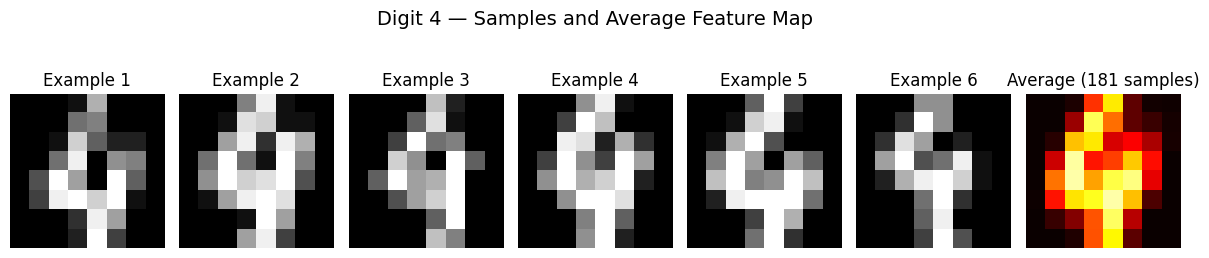

In [ ]:
#@title What is a feature?
#@markdown In machine learning, features are the measurable properties or characteristics used by a model to make predictions.
#@markdown
#@markdown For our simple classifier, each image has 64 features (one per pixel).
#@markdown During training, the model learns how different configurations of these pixel intensities correspond to specific digit labels (0–9).
#@markdown
#@markdown Below, we show several examples of a single digit alongside an average image.
#@markdown This average highlights which pixels are typically dark (close to intensity 16) or light (close to 0) — forming something like an archetype for that digit.

#@markdown ---
digit = 4 #@param {type:"number", min:0, max:9, step:1}

# Load the dataset
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()
X, y = digits.data, digits.target

# Select all examples of the chosen digit
X_digit = X[y == digit]
images = X_digit.reshape(-1, 8, 8)

# Show a few examples and then the average
n_examples = 6
fig, axes = plt.subplots(1, n_examples + 1, figsize=(12, 3))

# Plot individual examples
for i in range(n_examples):
    axes[i].imshow(images[i], cmap='gray', vmin=0, vmax=16)
    axes[i].set_title(f"Example {i+1}")
    axes[i].axis('off')

# Compute and plot the average
avg_image = images.mean(axis=0)
axes[-1].imshow(avg_image, cmap='hot', vmin=0, vmax=16)
axes[-1].set_title(f"Average ({len(images)} samples)")
axes[-1].axis('off')

plt.suptitle(f"Digit {digit} — Samples and Average Feature Map", fontsize=14)
plt.tight_layout()
plt.show()


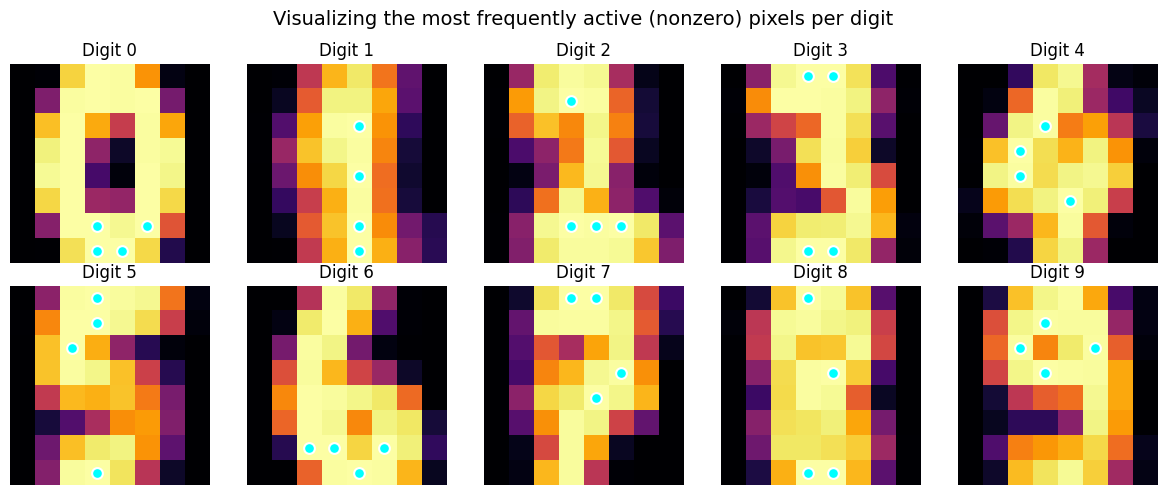

In [ ]:
#@title Are all features equally important?

#@markdown Not all pixels (features) contribute equally to a prediction.
#@markdown During training, the model assigns **weights** to each feature, reflecting how important it is for identifying a specific digit.
#@markdown
#@markdown Pixels that frequently activate for one digit but rarely for others receive higher weights.
#@markdown In the figures below, we visualize which pixels are most frequently active across the dataset — and which remain dark regardless of the digit.


fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for digit, ax in enumerate(axes.flat):
    # Get all samples of this digit
    X_digit = X[y == digit]

    # Compute frequency of activation (fraction of samples where pixel > 0)
    freq = (X_digit > 0).mean(axis=0).reshape(8, 8)

    # Find top 3 pixel coordinates
    flat_indices = np.argsort(freq.ravel())[::-1][:4]
    coords = np.array(np.unravel_index(flat_indices, freq.shape)).T

    # Plot frequency map
    ax.imshow(freq, cmap='inferno', vmin=0, vmax=1)
    ax.set_title(f"Digit {digit}")
    ax.axis('off')

    # Mark top 3 most frequently active pixels
    for (r, c) in coords:
        ax.scatter(c, r, color='cyan', s=60, edgecolors='white', linewidths=1.5)

plt.suptitle("Visualizing the most frequently active (nonzero) pixels per digit", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
#@title Selecting features for training
#@markdown Which features (pixels) are most useful for training our model?
#@markdown Which are least useful?
#@markdown
#@markdown This process of identifying and refining relevant features is known as feature engineering.
#@markdown
#@markdown Using the interactive matrix below, try selecting up to 8 pixels to train a model.
#@markdown Each selection represents a subset of features the model can use.
#@markdown When you click Train model, it learns from only those pixels and tests its accuracy.
#@markdown
#@markdown Observe how accuracy changes depending on:
#@markdown 1. **Which** pixels are selected.
#@markdown 2. **How many** features are used.


import numpy as np
from ipywidgets import Button, GridBox, Layout, VBox, HBox, Label
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Load dataset
digits = load_digits()
X, y = digits.data, digits.target

selected_pixels = set()
buttons = []

# Layouts
button_layout = Layout(width='28px', height='28px', padding='0', margin='1px')
grid_layout = Layout(
    grid_template_columns='repeat(8, 30px)',
    grid_gap='2px',
    justify_content='center'
)

# --- Create the grid of pixel buttons ---
for r in range(8):
    for c in range(8):
        b = Button(description='', layout=button_layout)
        def on_click(b, r=r, c=c):
            pos = (r, c)
            if pos in selected_pixels:
                selected_pixels.remove(pos)
                b.style.button_color = None
            elif len(selected_pixels) < 8:
                selected_pixels.add(pos)
                b.style.button_color = 'lightgreen'
            label.value = f"{len(selected_pixels)} selected: {sorted(selected_pixels)}"
        b.on_click(on_click)
        buttons.append(b)

grid = GridBox(children=buttons, layout=grid_layout)

# --- Labels and action buttons ---
label = Label(value="Select up to 8 pixels.")
train_button = Button(description="Train model", button_style='success', layout=Layout(width='120px'))
reset_button = Button(description="Reset", button_style='warning', layout=Layout(width='80px'))

# --- Functionality ---
from sklearn.metrics import accuracy_score, precision_score

def train_model(_):
    if not selected_pixels:
        label.value = "Select some pixels first."
        return
    idx = [r * 8 + c for (r, c) in selected_pixels]
    X_sel = X[:, idx]
    X_train, X_test, y_train, y_test = train_test_split(
        X_sel, y, test_size=0.3, random_state=42
    )
    clf = LogisticRegression(max_iter=2000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)

    label.value = f"Accuracy: {acc:.3f} ({len(idx)} pixels)"

def reset_selection(_):
    selected_pixels.clear()
    for b in buttons:
        b.style.button_color = None
    label.value = "Select up to 8 pixels."

train_button.on_click(train_model)
reset_button.on_click(reset_selection)

# --- Display everything ---
controls = HBox([train_button, reset_button])
display(VBox([grid, controls, label]))


In [ ]:
#@title Creating a rule-based model for predicting numbers

#@markdown If we drastically simplify the learning process, we can think of it as a system of “if… then…” rules.
#@markdown For instance:
#@markdown > *If certain pixels are dark in specific positions, then the digit is probably a 4.*
#@markdown
#@markdown In this section, you can build your own simple rule-based model:
#@markdown - Select 4 pixels that you believe define the digit “4.”
#@markdown - The model will evaluate your rule against the dataset and calculate its **precision** — how often it correctly predicts the digit.
#@markdown
#@markdown This illustrates the core idea behind classification models: using **statistical patterns** to make predictions based on feature combinations.

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Button, GridBox, Layout, VBox, HBox, Label, Output
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Load dataset
digits = load_digits()
X, y = digits.data, digits.target
digit = 4        # digit to explore
threshold = 12   # fixed intensity threshold

# --- LEFT: example digits (3 top, 2 bottom) ---
out_examples = Output()
with out_examples:
    imgs = X[y == digit].reshape(-1, 8, 8)
    random_indices = np.random.choice(len(imgs), size=6, replace=False)
    fig, axes = plt.subplots(2, 3, figsize=(4, 3.5))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.imshow(imgs[random_indices[i]], cmap="gray_r", vmin=0, vmax=16)
        ax.axis("off")
    plt.suptitle(f"Examples of '{digit}' (black ink on white)", fontsize=12)
    plt.tight_layout()
    plt.show()

# --- MIDDLE: most frequently black pixels ---
out_black = Output()
with out_black:
    black_fraction = (X[y == digit] >= 15).mean(axis=0).reshape(8, 8)

    fig, ax = plt.subplots(figsize=(3.3, 3.3))
    im = ax.imshow(
        black_fraction,
        cmap="inferno",
        vmin=0, vmax=1,
        origin="upper",
        extent=[0, 8, 8, 0],
        interpolation="nearest"
    )
    ax.set_xticks(np.arange(0.5, 8.5, 1))
    ax.set_yticks(np.arange(0.5, 8.5, 1))
    ax.set_xticklabels(range(8))
    ax.set_yticklabels(range(8))
    ax.set_xticks(np.arange(0, 9, 1), minor=True)
    ax.set_yticks(np.arange(0, 9, 1), minor=True)
    ax.grid(which="minor", color="white", linewidth=0.7)
    ax.tick_params(which="minor", length=0)
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")
    ax.set_title("Most Frequently Black Pixels")

    # top 4 darkest pixels
    flat_idx = np.argsort(black_fraction.ravel())[::-1][:4]
    coords = np.array(np.unravel_index(flat_idx, black_fraction.shape)).T
    for (r, c) in coords:
        ax.scatter(c + 0.5, r + 0.5, s=70, color="cyan", edgecolors="white", linewidths=1.2)
        ax.text(c + 0.5, r + 0.5, f"({r},{c})", color="black", fontsize=7,
                ha="center", va="center", fontweight="bold")

    plt.colorbar(im, ax=ax, fraction=0.046)
    plt.show()

# --- RIGHT: interactive pixel selector (row labels + bottom col labels) ---
selected_pixels = set()
buttons = []
button_layout = Layout(width="25px", height="25px", padding="0", margin="0 1px 1px 0")
label_layout = Layout(width="28px", height="20px", justify_content="center",
                      align_items="center", margin="2px 2px 2px 2px")
grid_children = []

# main 8×8 grid + left labels
for r in range(8):
    for c in range(-1, 8):
        if c == -1:
            grid_children.append(Label(value=str(r), layout=label_layout))
        else:
            b = Button(description="", layout=button_layout)
            def on_click(b, r=r, c=c):
                pos = (r, c)
                if pos in selected_pixels:
                    selected_pixels.remove(pos)
                    b.style.button_color = None
                elif len(selected_pixels) < 4:
                    selected_pixels.add(pos)
                    b.style.button_color = "lightgreen"
                status.value = f"{len(selected_pixels)} selected: {sorted(selected_pixels)}"
            b.on_click(on_click)
            grid_children.append(b)
            buttons.append(b)

# bottom row for column labels
for c in range(-1, 8):
    grid_children.append(Label(value=str(c) if c >= 0 else "", layout=label_layout))

grid_layout = Layout(grid_template_columns="repeat(9, 30px)", grid_gap="2px", justify_content="center")
grid = GridBox(children=grid_children, layout=grid_layout)

evaluate_button = Button(description="Evaluate rule", button_style="success", layout=Layout(width="130px"))
reset_button = Button(description="Reset", button_style="warning", layout=Layout(width="80px"))
status = Label(value="Select exactly 4 pixels.")

# --- Fixed rule: ALL ≥ threshold ---
def apply_rule(X_subset, idx, thr):
    vals = X_subset[:, idx]
    return (vals >= thr).all(axis=1).astype(int)

def evaluate_rule(_):
    if len(selected_pixels) != 4:
        status.value = "Please select exactly 4 pixels."
        return
    idx = [r * 8 + c for (r, c) in sorted(selected_pixels)]
    y_binary = (y == digit).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_binary, test_size=0.3, random_state=42, stratify=y_binary)
    y_pred = apply_rule(X_test, idx, threshold)
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
    precision = TP / (TP + FP) if (TP + FP) else 0.0
    status.value = f"Pixels={sorted(selected_pixels)} | Precision for '{digit}' = {precision:.3f}"

def reset_selection(_):
    selected_pixels.clear()
    for b in buttons:
        b.style.button_color = None
    status.value = "Select exactly 4 pixels."

evaluate_button.on_click(evaluate_rule)
reset_button.on_click(reset_selection)
controls_line = HBox([evaluate_button, reset_button])
right_panel = VBox([grid, controls_line, status])

# --- Combine all panels ---
display(HBox([out_examples, out_black, right_panel]))
